# 202 Generating the feature embeddings of original datasets and MolMM's outputs

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from MolMM import *
import numpy as np
import pickle
from argparse import ArgumentParser
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
from copy import deepcopy
import pandas as pd
import seaborn as sns
warnings.filterwarnings('ignore') 
from torch.utils.data.dataset import ConcatDataset,Subset
# import seaborn as sns

seeds=42
torch.manual_seed(seeds)
np.random.seed(seeds)
torch.cuda.manual_seed_all(seeds)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.determinstic = True

cpu = torch.device("cpu")

[1]


In [2]:
import os
from collections import defaultdict

folder_path = 'ckpt'
ckpt_dict = defaultdict(str)
for dirpath, dirnames, filenames in os.walk(folder_path):
    for filename in filenames:
        if ('checkpoints' in dirpath):
            pathlist=os.path.join(dirpath, filename).split('/')
            ckpt_dict[pathlist[1]+'/'+pathlist[2]+'/'+pathlist[3]] = os.path.join(dirpath, filename)

In [3]:
import os
from collections import defaultdict

folder_path = 'ckpt'
ckpt_dict = defaultdict(str)
for dirpath, dirnames, filenames in os.walk(folder_path):
    for filename in filenames:
        if ('checkpoints' in dirpath and 'result' in dirpath):
            pathlist=os.path.join(dirpath, filename).split('/')
            ckpt_dict[pathlist[1]+'/'+pathlist[2]+'/'+pathlist[3]] = os.path.join(dirpath, filename)

In [4]:
# import umap
from sklearn.manifold import TSNE
def plot_feat(feat_,legend=False,feat_list=None,name=None):
    assert feat_list is not None
    name_list=pd.read_csv('./MolMM/csv/data_extra/competitive_clean.csv')['drug'].tolist()
    size_dict = {
        'substrates_classes':20,
        'inhibitors_classes':20,
        'substrates_refine':50,
        'inhibitors_refine':50,
        'excipients':20,
        'competitive':80,
    }
    color_list=['#e41a1c','#e41a1c','#377eb8','#377eb8','#4daf4a','#4daf4a']
    # color_list=['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f']
    # color_list=['#d01c8b','#f1b6da','#b8e186','#4dac26','#f7f7f7','#f7f7f7']
    color_dict={ k:v for k,v in zip(size_dict.keys(),color_list) }
    marker_dict = {
        'substrates_classes':'^',
        'inhibitors_classes':'o',
        'substrates_refine':'^',
        'inhibitors_refine':'o',
        'excipients':',',
        'competitive':',',
    }
    if (feat_list is None):
        feat_list = feat_.keys()
        
    feat={}
    for task in feat_list:
        try:
            feat[task] = feat_[task].cpu().numpy()
        except:
            pass
    compounds = np.concatenate([ v for v in feat.values() ])
        
    # umap_reducer = umap.UMAP(n_neighbors=15, min_dist = 0.1, n_components=2, random_state=42)
    umap_reducer = TSNE(n_components=2)
    umap_embedding = umap_reducer.fit_transform(compounds)
    
    compound_labels = np.array([task for task in feat.keys() for _ in range(feat[task].shape[0])])

    fig, ax = plt.subplots(figsize=(10, 6))
    
    if len(feat_list)==1:
        pass
    else:
        for task in feat_list:
            if (task in ['extra']):
                continue
            mask = compound_labels==task
            alpha = 0.8 if (task in ['excipients','competitive']) else 0.5
        
                # data=pd.DataFrame(data={'x':umap_embedding[mask][:, 0],'y':umap_embedding[mask][:, 1]}),
            df = sns.regplot(
                x=umap_embedding[mask][:, 0],
                y=umap_embedding[mask][:, 1],
                fit_reg=False,
                x_jitter = 0.2, y_jitter = 0.2,
                scatter_kws = {
                    'alpha' : 0.3 if 'classes' in task else 0.7,
                    'color':color_dict[task],
                    's':[size_dict[task] for _ in range(feat[task].shape[0])],
                },
                marker=marker_dict[task],
                label=task,
            )
            
    
    if ('extra' in feat.keys()):
        pass
    elif 'competitive' in feat_list:
        for i, (x, y) in enumerate(umap_embedding[-feat['competitive'].shape[0]:]):
            ax.text(x, y, name_list[i].split('_')[0], fontsize=10, ha='left')
    
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
    if (legend):
        ax.legend(loc=3)
    if name is not None:
        plt.savefig('image/'+'feat_emb_'+name+'.png',bbox_inches='tight',transparent=True,)
    plt.show()
    

In [5]:
def get_model(task,name,task_list):
    args = {}
    args['dir'] = './results/'+task
    args['ckpt_dir_1'] = './ckpt/'+task
    args['name'] = name
    args['task_list'] = task_list
    args['bar']=False
    return get_models(args)

In [6]:
class LeNet_SHAP(LeNet_single):
    def __init__(self,task_list=[],N_way={}):
        super(LeNet_SHAP, self).__init__(task_list=task_list,N_way=N_way)
        with open('./params/indices_list.pkl', 'rb') as f:
            self.indices_list = pickle.load(f)
        self.indices = pd.read_csv('./params/molinfo.csv')['indices'].tolist()
            
    def tab2image(self,x):
        x = x.view(x.shape[0],-1)[:,self.indices]
        arr_res = []
        for idict in self.indices_list:
            indices,idx = idict['indices'],idict['idx']
            arr_1d = torch.zeros((x.shape[0],37*37),device=x.device)
            arr_1d[:,indices] = x[:,idx]
            arr_res.append(arr_1d.view(x.shape[0],1,37,37))
        x = torch.cat(arr_res, axis=1)
        return x
        
    def forward(self, x):
        x = self.tab2image(x)
        x = self.shared_layers(x)
        task = self.task_list[0]
        x = self.lst[task](self.output[task](x))
        x = (x[...,1]-x[...,0]).unsqueeze(-1)
        # x = F.softmax(self.lst[task](self.output[task](x)))
        # x = torch.log(x / (1 - x))
        return x
    
class DNN_SHAP(DNN_single):
    def __init__(self, task_list=[],N_way={}):
        super(DNN_SHAP, self).__init__(task_list=task_list,N_way=N_way)
        
    def forward(self, x):
        x = self.shared_layers(x)
        task = self.task_list[0]
        x = self.lst[task](self.output[task](x))
        x = (x[...,1]-x[...,0]).unsqueeze(-1)
        return x

In [7]:
train_data_sub,ft_data_sub,ft_test_data_sub,finetune_sub = get_model(
    'sub',
    'CNN_pH_kfold_val_meta_guide_inv_freeze',
    ['substrates_classes']
)
train_data_inh,ft_data_inh,ft_test_data_inh,finetune_inh = get_model(
    'inh',
    'CNN_pH_kfold_nval_meta_guide_inv_freeze',
    ['inhibitors_classes']
)
# train_data_sub,ft_data_sub,ft_test_data_sub,finetune_sub = get_model('sub','CNN_pH_kfold_val_meta_guide_freeze',['substrates_classes'])
best_model_inhibitors = finetune_inh
best_model_substrates = finetune_sub

Succeed to load plot model!
excluding inhibitors_refine from inhibitors_classes
inhibitors_classes's overlap  79 0.4438202247191011
inhibitors_classes's conflict  10 0.12658227848101267

excluding competitive from inhibitors_classes
inhibitors_classes's overlap  8 0.6153846153846154
inhibitors_classes's conflict  No label for conflict!

excluding substrates_refine from substrates_classes
substrates_classes's overlap  344 0.4858757062146893
substrates_classes's conflict  19 0.055232558139534885

excluding competitive from substrates_classes
substrates_classes's overlap  11 0.8461538461538461
substrates_classes's conflict  No label for conflict!

excluding substrates_refine from allocrites_classes
allocrites_classes's overlap  351 0.4957627118644068
allocrites_classes's conflict  25 0.07122507122507123

excluding competitive from allocrites_classes
allocrites_classes's overlap  12 0.9230769230769231
allocrites_classes's conflict  No label for conflict!

excluding inhibitors_refine from a

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



substrates_classes_labels total [3810] size [1438, 2372]

Begin to fine-tune, Loading PTMs, ckpt/meta_sub/CNN_pH_kfold_val_meta_guide_inv_stop/version_0/checkpoints/epoch=158-step=1590.ckpt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


substrates_classes_labels total [444] size [184, 260]



`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   test_substrates_classes_acc          0.6777201890945435
   test_substrates_classes_auc          0.7272861003875732
  test_substrates_classes_loss          0.6462023258209229
 test_substrates_classes_pr_auc         0.6977081894874573
test_substrates_classes_precision       0.6685817241668701
 test_substrates_classes_recall          0.679252028465271
         test_total_acc                 0.6777201890945435
         test_total_auc                 0.7272861003875732
         test_total_loss                0.6462023258209229
        test_total_pr_auc               0.6977081894874573
───────────────────────────────────────────────────────────────────────────────────────────────────────────────

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


inhibitors_classes_labels total [3500] size [1323, 2177]

Begin to fine-tune, Loading PTMs, ckpt/meta_inh/CNN_pH_kfold_nval_meta_guide_inv_stop/version_0/checkpoints/epoch=114-step=1150.ckpt
inhibitors_classes_labels total [134] size [69, 65]



`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 37.76it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   test_inhibitors_classes_acc          0.6818652749061584
   test_inhibitors_classes_auc          0.7800040245056152
  test_inhibitors_classes_loss          0.6482231616973877
 test_inhibitors_classes_pr_auc         0.7513613700866699
test_inhibitors_classes_precision       0.6977784633636475
 test_inhibitors_classes_recall         0.7092331051826477
         test_total_acc                 0.6818652749061584
         test_total_auc                 0.7800040245056152
         test_total_loss                0.6482231616973877
        test_total_pr_auc               0.7513613700866699
───────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [8]:
name= 'CNN_pH_kfold_nval'
name_list = name.split('_')
data_module=DataModule(name_list,use_all=False)
data_module.prepare_data()
device = torch.device("cuda")

excluding inhibitors_refine from inhibitors_classes
inhibitors_classes's overlap  79 0.4438202247191011
inhibitors_classes's conflict  10 0.12658227848101267

excluding competitive from inhibitors_classes
inhibitors_classes's overlap  8 0.6153846153846154
inhibitors_classes's conflict  No label for conflict!

excluding substrates_refine from substrates_classes
substrates_classes's overlap  344 0.4858757062146893
substrates_classes's conflict  19 0.055232558139534885

excluding competitive from substrates_classes
substrates_classes's overlap  11 0.8461538461538461
substrates_classes's conflict  No label for conflict!

excluding substrates_refine from allocrites_classes
allocrites_classes's overlap  351 0.4957627118644068
allocrites_classes's conflict  25 0.07122507122507123

excluding competitive from allocrites_classes
allocrites_classes's overlap  12 0.9230769230769231
allocrites_classes's conflict  No label for conflict!

excluding inhibitors_refine from allocrites_classes
allocrites

In [9]:
it = best_model_inhibitors.task_list[0]
st = best_model_substrates.task_list[0]

res_o = {}
feat_o = {}
feat_CNN = {}
for task in [it,st]:
    feat_o[task]={}
    feat_CNN[task]={}
    res_o[task]={}

best_model_inhibitors.eval()
model = best_model_inhibitors.model.to(device)

for task in data_module.X.keys():
    with torch.no_grad():
        x = data_module.X[task].to(device)
        feat_CNN[it][task] = F.sigmoid(model.shared_layers(x))
        feat_o[it][task] = F.sigmoid(model(x, best_model_inhibitors.task_list)[it])
        res_o[it][task] = F.softmax(best_model_inhibitors(best_model_inhibitors.task_list[0],x))[:,1]

best_model_substrates.eval()
model = best_model_substrates.model.to(device)

for task in data_module.X.keys():
    with torch.no_grad():
        x = data_module.X[task].to(device)
        feat_CNN[st][task] = F.sigmoid(model.shared_layers(x))
        feat_o[st][task] = F.sigmoid(model(x, best_model_substrates.task_list)[st])
        res_o[st][task] = F.softmax(best_model_substrates(st,x))[:,1]

In [10]:
from collections import defaultdict
exc_inh = defaultdict(list)
t = best_model_inhibitors.task_list[0]
df_t = pd.read_csv(os.path.join('./MolMM/',data_module.path[t],t+'_clean.csv'))

for i in range(len(df_t)):
    data = df_t.iloc[i]
    exc_inh[data['smiles']].append(data['label'])

rt = data_module.test_task[t]
if (t!=rt):
    df_rt = pd.read_csv(os.path.join('./MolMM/',data_module.path[rt],rt+'_clean.csv'))
    print(t,rt)
    for i in range(len(df_rt)):
        data = df_rt.iloc[i]
        if (len(exc_inh[data['smiles']])==0):
            exc_inh[data['smiles']].append(None)
        exc_inh[data['smiles']].append(data['label'])
    
exc_sub = defaultdict(list)
t = best_model_substrates.task_list[0]
df_t = pd.read_csv(os.path.join('./MolMM/',data_module.path[t],t+'_clean.csv'))

for i in range(len(df_t)):
    data = df_t.iloc[i]
    exc_sub[data['smiles']].append(data['label'])

rt = data_module.test_task[t]
if (t!=rt):
    df_rt = pd.read_csv(os.path.join('./MolMM/',data_module.path[rt],rt+'_clean.csv'))
    print(t,rt)
    for i in range(len(df_rt)):
        data = df_rt.iloc[i]
        if (len(exc_sub[data['smiles']])==0):
            exc_sub[data['smiles']].append(None)
        exc_sub[data['smiles']].append(data['label'])

df = pd.read_csv('./MolMM/csv/data_extra/competitive.csv')
df['pred_inhibitors'] = res_o[it]['competitive'].cpu().numpy()
df['pred_substrates'] = res_o[st]['competitive'].cpu().numpy()
df['inh_in_train'] = [ exc_inh[smi] for smi in df['smiles'] ]
df['sub_in_train'] = [ exc_sub[smi] for smi in df['smiles'] ]
df = df[['drug','smiles','pred_inhibitors','inh_in_train','pred_substrates','sub_in_train']]
df.to_csv('result_competitive.csv',index=False)
df['pred_inhibitors'] = [ round(s,2) for s in df['pred_inhibitors'] ]
df['pred_substrates'] = [ round(s,2) for s in df['pred_substrates'] ]

inhibitors_classes inhibitors_refine
substrates_classes substrates_refine


In [11]:
df

,drug,smiles,pred_inhibitors,inh_in_train,pred_substrates,sub_in_train
0,Morphine,CN1CCC23c4c5ccc(O)c4OC2C(O)C=CC3C1C5,0.15,"[None, False]",0.18,[True]
1,Vinblastine,CCC1(O)CC2CN(CCc3c([nH]c4ccccc34)C(C(=O)OC)(c3...,0.24,[True],0.97,"[True, True]"
2,Nicardipine,COC(=O)C1=C(C)NC(C)=C(C(=O)OCCN(C)Cc2ccccc2)C1...,0.77,"[True, True]",0.77,"[False, False]"
3,Hoechst_33342,CCOc1ccc(-c2nc3ccc(-c4nc5ccc(N6CCN(C)CC6)cc5[n...,0.77,[False],0.61,[True]
4,Paclitaxel,CC(=O)OC1C(=O)C2(C)C(O)CC3OCC3(OC(C)=O)C2C(OC(...,0.53,"[True, False]",0.93,"[True, True]"
5,Rhodamine_123,COC(=O)c1ccccc1-c1c2ccc(=N)cc-2oc2cc(N)ccc12,0.10,[],0.72,[True]
6,Verapamil,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,0.60,"[True, True]",0.86,[True]
7,Tariquidar,COc1cc2c(cc1OC)CN(CCc1ccc(NC(=O)c3cc(OC)c(OC)c...,0.73,"[True, True]",0.96,"[None, True]"
8,Valproic_acid,CCCC(CCC)C(=O)O,0.08,[],0.31,[]
9,Colchicine,COc1cc2c(c(OC)c1OC)-c1ccc(OC)c(=O)cc1C(NC(C)=O...,0.69,"[None, False]",0.63,"[True, True]"


In [12]:
exc_inh = set()
t = best_model_inhibitors.task_list[0]
rt = data_module.test_task[t]
df_t = pd.read_csv(os.path.join('./MolMM/',data_module.path[t],t+'_clean.csv'))
df_rt = pd.read_csv(os.path.join('./MolMM/',data_module.path[rt],rt+'_clean.csv'))
tmp = pd.concat([df_t,df_rt])
for i in range(len(tmp)):
    data = tmp.iloc[i]
    exc_inh.add(data['smiles'])
    
exc_sub = set()
t = best_model_substrates.task_list[0]
rt = data_module.test_task[t]
df_t = pd.read_csv(os.path.join('./MolMM/',data_module.path[t],t+'_clean.csv'))
df_rt = pd.read_csv(os.path.join('./MolMM/',data_module.path[rt],rt+'_clean.csv'))
tmp = pd.concat([df_t,df_rt])
for i in range(len(tmp)):
    data = tmp.iloc[i]
    exc_sub.add(data['smiles'])

df = pd.read_csv('./MolMM/csv/data_extra/excipients.csv')
df['pred_inhibitors'] = res_o[it]['excipients'].cpu().numpy()
df['pred_substrates'] = res_o[st]['excipients'].cpu().numpy()
df['inh_in_train'] = [ smi in exc_inh for smi in df['smiles'] ]
df['sub_in_train'] = [ smi in exc_sub for smi in df['smiles'] ]
df = df[['drug','pred_inhibitors','inh_in_train','pred_substrates','sub_in_train']]
df.to_csv('result_excipients.csv',index=False)
df['pred_inhibitors'] = [ round(s,2) for s in df['pred_inhibitors'] ]
df['pred_substrates'] = [ round(s,2) for s in df['pred_substrates'] ]

In [13]:
df

,drug,pred_inhibitors,inh_in_train,pred_substrates,sub_in_train
0,Tween 20,0.58,False,0.99,False
1,Tween 40,0.62,False,0.99,False
2,Tween 60,0.63,False,0.99,False
3,Tween 80,0.62,False,0.99,False
4,Span 20,0.38,False,0.63,False
5,Span 40,0.47,False,0.78,False
6,Span 60,0.49,False,0.82,False
7,Span 80,0.43,False,0.76,False
8,Sucrose Monolaurate,0.20,False,0.88,False
9,Sucrose Monopalmitate,0.28,False,0.92,False


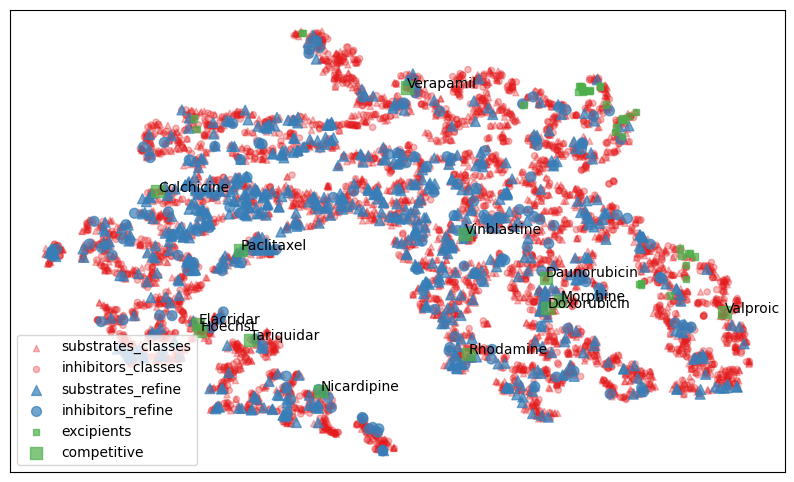

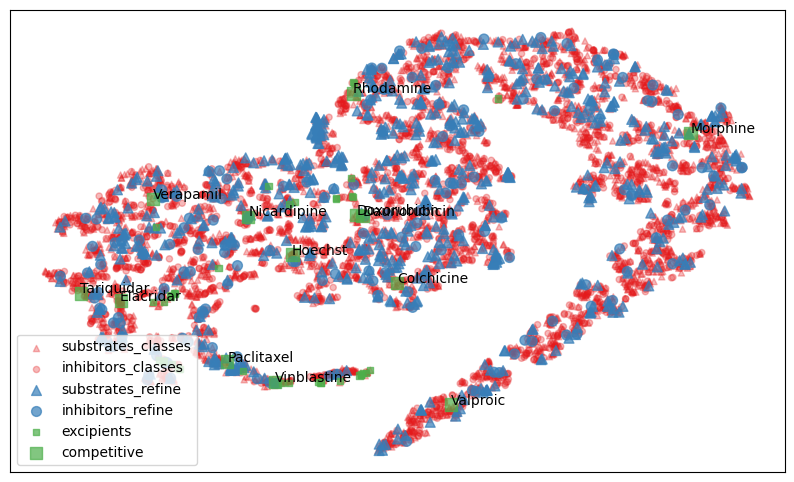

In [14]:
task_list = ['substrates_classes','inhibitors_classes','substrates_refine','inhibitors_refine','excipients','competitive']

feat={}
for task in feat_o[it]:
    feat[task] = feat_o[it][task]
plot_feat(feat,feat_list=task_list,legend=True,name='inh')

feat={}
for task in feat_o[st]:
    feat[task] = feat_o[st][task]
plot_feat(feat,feat_list=task_list,legend=True,name='sub')

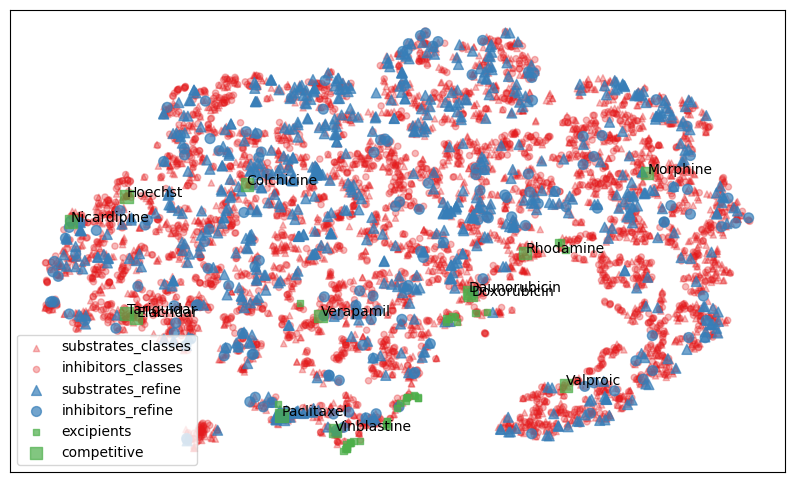

In [15]:
com_feat_c = {}
for (ki,vi),(ks,vs) in zip(feat_CNN[it].items(),feat_CNN[st].items()):
    com_feat_c[ki] = torch.cat([vi,vs],dim=1)

com_feat_o = {}
for (ki,vi),(ks,vs) in zip(feat_o[it].items(),feat_o[st].items()):
    if (ki == 'extra'):
        continue
    com_feat_o[ki] = torch.cat([feat_o[it][ki],feat_o[st][ks]],dim=1)

task_list = ['substrates_classes','inhibitors_classes','substrates_refine','inhibitors_refine','excipients','competitive']
plot_feat(com_feat_o,feat_list=task_list,legend=True,name='merge')